<a href="https://colab.research.google.com/github/shreyamanapure/nuclei_identifier/blob/main/partA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d ipateam/nuinsseg

 99% 1.49G/1.52G [00:21<00:00, 59.5MB/s]
100% 1.52G/1.52G [00:22<00:00, 73.8MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/nuinsseg.zip')
zip_ref.extractall('/content/Data')
zip_ref.close()

In [ ]:
import os
import shutil

def prune_subdirectories(base_dir, keep_dirs):
    # Iterate through each subdirectory in the base directory
    for root_dir in os.listdir(base_dir):
        root_path = os.path.join(base_dir, root_dir)
        if os.path.isdir(root_path):
            print(f"Processing: {root_path}")
            # List all subdirectories inside the current root directory
            for sub_dir in os.listdir(root_path):
                sub_path = os.path.join(root_path, sub_dir)
                # If the subdirectory isn't in the keep list, delete it
                if os.path.isdir(sub_path) and sub_dir not in keep_dirs:
                    print(f"Deleting: {sub_path}")
                    shutil.rmtree(sub_path)
                elif os.path.isdir(sub_path):
                    print(f"Keeping: {sub_path}")

base_directory = "/content/Data"
directories_to_keep = ['tissue images', 'mask binary without border', 'label masks modify']

prune_subdirectories(base_directory, directories_to_keep)

Processing: /content/Data/human spleen
Deleting: /content/Data/human spleen/stacked mask
Deleting: /content/Data/human spleen/label masks
Deleting: /content/Data/human spleen/overlay_save_path
Keeping: /content/Data/human spleen/mask binary without border
Keeping: /content/Data/human spleen/label masks modify
Keeping: /content/Data/human spleen/tissue images
Deleting: /content/Data/human spleen/mask binary
Deleting: /content/Data/human spleen/nuclei border
Deleting: /content/Data/human spleen/vague areas
Deleting: /content/Data/human spleen/distance maps
Deleting: /content/Data/human spleen/weighted_maps_erode
Deleting: /content/Data/human spleen/weighted_maps
Deleting: /content/Data/human spleen/mask binary without border erode
Deleting: /content/Data/human spleen/Imagj_zips
Processing: /content/Data/mouse fat (white and brown)_subscapula
Deleting: /content/Data/mouse fat (white and brown)_subscapula/stacked mask
Deleting: /content/Data/mouse fat (white and brown)_subscapula/label mas

In [ ]:
import os
import cv2
import numpy as np
import json
import shutil
from sklearn.model_selection import train_test_split

def get_image_mask_pairs(data_dir):
    image_paths = []
    mask_paths = []

    for root, _, files in os.walk(data_dir):
        if 'tissue images' in root:
            for file in files:
                if file.endswith('.png'):
                    image_paths.append(os.path.join(root, file))
                    mask_paths.append(os.path.join(root.replace('tissue images', 'label masks modify'), file.replace('.png', '.tif')))

    return image_paths, mask_paths

def mask_to_polygons(mask, epsilon=1.0):
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    polygons = []
    for contour in contours:
        if len(contour) > 2:
            poly = contour.reshape(-1).tolist()
            if len(poly) > 4:  # Ensure valid polygon
                polygons.append(poly)
    return polygons

def process_data(image_paths, mask_paths, output_dir):
    annotations = []
    images = []
    image_id = 0
    ann_id = 0

    for img_path, mask_path in zip(image_paths, mask_paths):
        image_id += 1
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        # Copy image to output directory
        shutil.copy(img_path, os.path.join(output_dir, os.path.basename(img_path)))

        images.append({
            "id": image_id,
            "file_name": os.path.basename(img_path),
            "height": img.shape[0],
            "width": img.shape[1]
        })

        unique_values = np.unique(mask)
        for value in unique_values:
            if value == 0:  # Ignore background
                continue

            object_mask = (mask == value).astype(np.uint8) * 255
            polygons = mask_to_polygons(object_mask)

            for poly in polygons:
                ann_id += 1
                annotations.append({
                    "id": ann_id,
                    "image_id": image_id,
                    "category_id": 1,  # Only one category: Nuclei
                    "segmentation": [poly],
                    "area": cv2.contourArea(np.array(poly).reshape(-1, 2)),
                    "bbox": list(cv2.boundingRect(np.array(poly).reshape(-1, 2))),
                    "iscrowd": 0
                })

    coco_output = {
        "images": images,
        "annotations": annotations,
        "categories": [{"id": 1, "name": "Nuclei"}]
    }

    with open(os.path.join(output_dir, 'coco_annotations.json'), 'w') as f:
        json.dump(coco_output, f)

def main():
    data_dir = '/content/Data'
    output_dir = 'COCO_output'
    train_dir = os.path.join(output_dir, 'train')
    val_dir = os.path.join(output_dir, 'val')

    # Create output directories
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    image_paths, mask_paths = get_image_mask_pairs(data_dir)

    # Split data into train and val
    train_img_paths, val_img_paths, train_mask_paths, val_mask_paths = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

    # Process train and val data
    process_data(train_img_paths, train_mask_paths, train_dir)
    process_data(val_img_paths, val_mask_paths, val_dir)

if __name__ == '__main__':
    main()

In [ ]:
len('/content/COCO_output/train'), len('/content/COCO_output/val')

(26, 24)

In [ ]:
import json
import os
import shutil
import yaml

# Function to convert images to YOLO format
def convert_to_yolo(input_images_path, input_json_path, output_images_path, output_labels_path):
    # Open JSON file containing image annotations
    f = open(input_json_path)
    data = json.load(f)
    f.close()

    # Create directories for output images and labels
    os.makedirs(output_images_path, exist_ok=True)
    os.makedirs(output_labels_path, exist_ok=True)

    # List to store filenames
    file_names = []
    for filename in os.listdir(input_images_path):
        if filename.endswith(".png"):
            source = os.path.join(input_images_path, filename)
            destination = os.path.join(output_images_path, filename)
            shutil.copy(source, destination)
            file_names.append(filename)

    # Function to get image annotations
    def get_img_ann(image_id):
        return [ann for ann in data['annotations'] if ann['image_id'] == image_id]

    # Function to get image data
    def get_img(filename):
        return next((img for img in data['images'] if img['file_name'] == filename), None)

    # Iterate through filenames and process each image
    for filename in file_names:
        img = get_img(filename)
        img_id = img['id']
        img_w = img['width']
        img_h = img['height']
        img_ann = get_img_ann(img_id)

        # Write normalized polygon data to a text file
        if img_ann:
            with open(os.path.join(output_labels_path, f"{os.path.splitext(filename)[0]}.txt"), "a") as file_object:
                for ann in img_ann:
                    current_category = ann['category_id'] - 1
                    polygon = ann['segmentation'][0]
                    normalized_polygon = [format(coord / img_w if i % 2 == 0 else coord / img_h, '.6f') for i, coord in enumerate(polygon)]
                    file_object.write(f"{current_category} " + " ".join(normalized_polygon) + "\n")

# Function to create a YAML file for the dataset
def create_yaml(input_json_path, output_yaml_path, train_path, val_path, test_path=None):
    with open(input_json_path) as f:
        data = json.load(f)

    # Extract the category names
    names = [category['name'] for category in data['categories']]

    # Number of classes
    nc = len(names)

    # Create a dictionary with the required content
    yaml_data = {
        'names': names,
        'nc': nc,
        'test': test_path if test_path else '',
        'train': train_path,
        'val': val_path
    }

    # Write the dictionary to a YAML file
    with open(output_yaml_path, 'w') as file:
        yaml.dump(yaml_data, file, default_flow_style=False)


if __name__ == "__main__":
    base_input_path = "COCO_output/"
    base_output_path = "yolo_dataset/"

    # Processing validation dataset (if needed)
    convert_to_yolo(
        input_images_path=os.path.join(base_input_path, "val"),
        input_json_path=os.path.join(base_input_path, "val/coco_annotations.json"),
        output_images_path=os.path.join(base_output_path, "valid/images"),
        output_labels_path=os.path.join(base_output_path, "valid/labels")
    )

    # Processing training dataset
    convert_to_yolo(
        input_images_path=os.path.join(base_input_path, "train"),
        input_json_path=os.path.join(base_input_path, "train/coco_annotations.json"),
        output_images_path=os.path.join(base_output_path, "train/images"),
        output_labels_path=os.path.join(base_output_path, "train/labels")
    )

    # Creating the YAML configuration file
    create_yaml(
        input_json_path=os.path.join(base_input_path, "train/coco_annotations.json"),
        output_yaml_path=os.path.join(base_output_path, "data.yaml"),
        train_path="train/images",
        val_path="valid/images",
        test_path='../test/images'  # or None if not applicable
    )

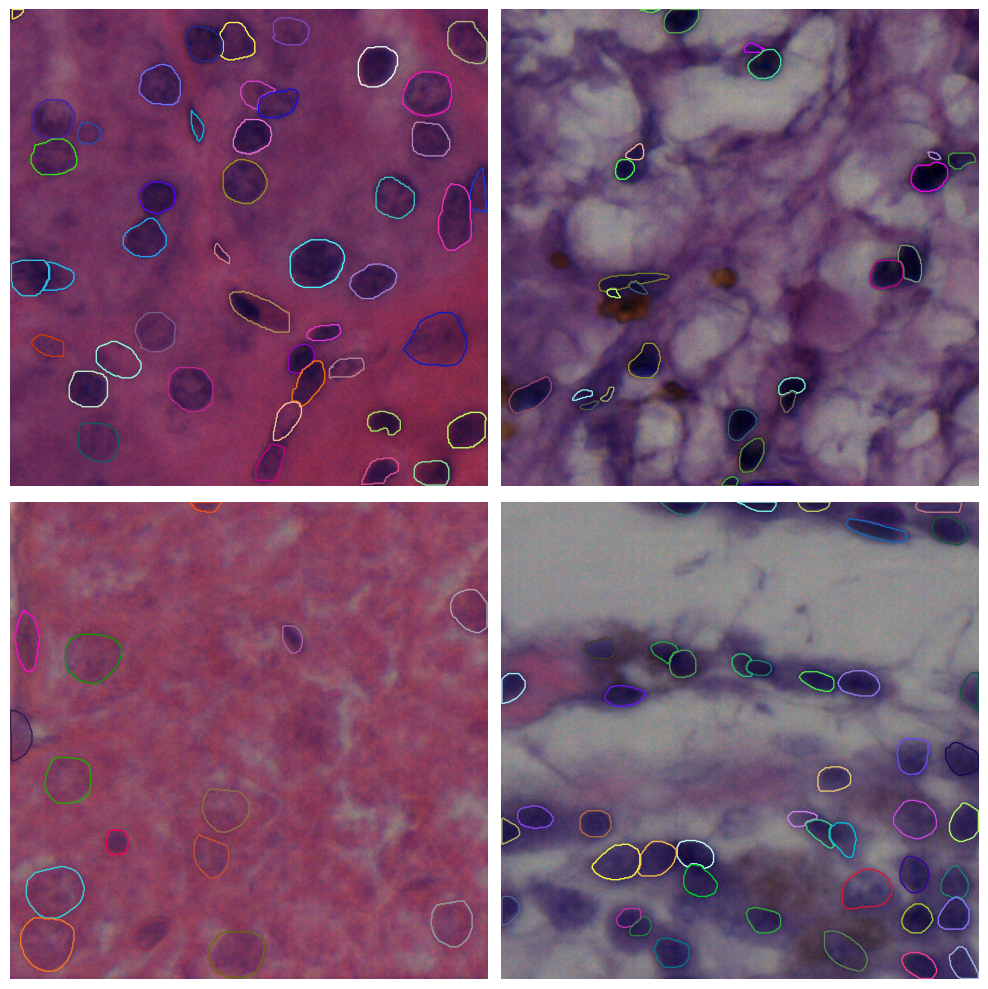

In [ ]:
import os
import random
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import numpy as np

def display_images_with_coco_annotations(image_paths, annotations, display_type='both'):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    for ax, img_path in zip(axs.ravel(), image_paths):
        # Load image using OpenCV and convert it from BGR to RGB color space
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax.imshow(image)
        ax.axis('off')  # Turn off the axes

        # Get image filename to match with annotations
        img_filename = os.path.basename(img_path)
        img_id = next(item for item in annotations['images'] if item["file_name"] == img_filename)['id']

        # Filter annotations for the current image
        img_annotations = [ann for ann in annotations['annotations'] if ann['image_id'] == img_id]

        # Generate random colors for each annotation
        colors = [tuple(np.random.rand(3)) for _ in img_annotations]

        for ann, color in zip(img_annotations, colors):
            # Display bounding box
            if display_type in ['bbox', 'both']:
                bbox = ann['bbox']
                rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                                         linewidth=1, edgecolor=color,
                                         facecolor='none')
                ax.add_patch(rect)

            # Display segmentation polygon
            if display_type in ['seg', 'both']:
                for seg in ann['segmentation']:
                    poly = [(seg[i], seg[i+1]) for i in range(0, len(seg), 2)]
                    polygon = patches.Polygon(poly, closed=True, edgecolor=color,
                                              fill=False)
                    ax.add_patch(polygon)

    plt.tight_layout()
    plt.show()

# Load COCO annotations
with open('COCO_output/train/coco_annotations.json', 'r') as f:
    annotations = json.load(f)

# Get all image files
image_dir = "COCO_output/train/"
all_image_files = [os.path.join(image_dir, img['file_name']) for img in annotations['images']]
random_image_files = random.sample(all_image_files, 4)

# Choose between 'bbox', 'seg', or 'both'
display_type = 'seg'
display_images_with_coco_annotations(random_image_files, annotations, display_type)


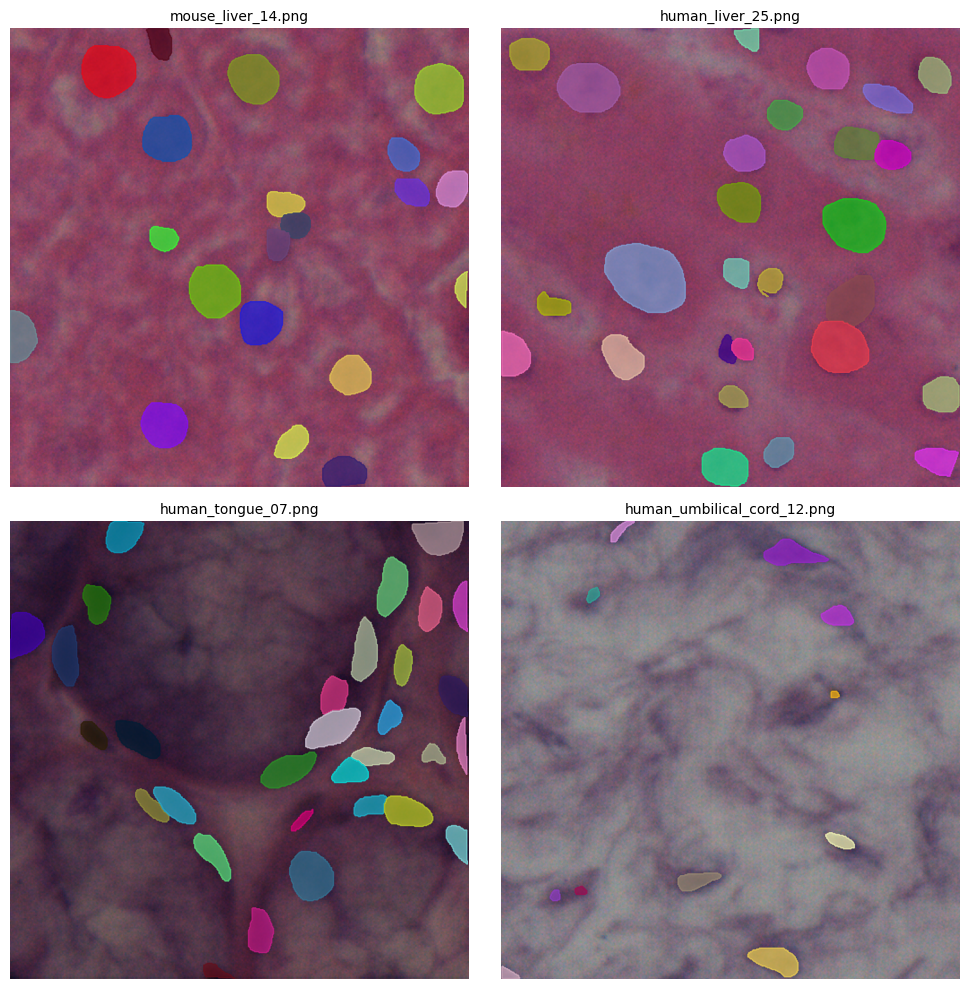

In [ ]:
import os
import random
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import numpy as np

def display_images_with_coco_annotations(image_paths, annotations, display_type='both'):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    for ax, img_path in zip(axs.ravel(), image_paths):
        # Load image using OpenCV and convert it from BGR to RGB color space
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax.imshow(image)
        ax.axis('off')  # Turn off the axes

        # Get image filename to match with annotations
        img_filename = os.path.basename(img_path)
        img_id = next(item for item in annotations['images'] if item["file_name"] == img_filename)['id']

        # Filter annotations for the current image
        img_annotations = [ann for ann in annotations['annotations'] if ann['image_id'] == img_id]

        colors = [np.random.rand(3,) for _ in range(len(img_annotations))]  # Generate random colors

        for ann, color in zip(img_annotations, colors):
            # Display bounding box
            if display_type in ['bbox', 'both']:
                bbox = ann['bbox']
                rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                                         linewidth=1, edgecolor=color,
                                         facecolor='none')
                ax.add_patch(rect)

            # Display segmentation polygon
            if display_type in ['seg', 'both']:
                for seg in ann['segmentation']:
                    poly = [(seg[i], seg[i+1]) for i in range(0, len(seg), 2)]
                    polygon = patches.Polygon(poly, closed=True, edgecolor=color,
                                              fill=True, facecolor=color, alpha=0.7)
                    ax.add_patch(polygon)

        ax.set_title(img_filename, fontsize=10)

    plt.tight_layout()
    plt.show()

# Load COCO annotations
with open('COCO_output/train/coco_annotations.json', 'r') as f:
    annotations = json.load(f)


# Get all image files
image_dir = "COCO_output/train/"
all_image_files = [os.path.join(image_dir, img['file_name']) for img in annotations['images']]
random_image_files = random.sample(all_image_files, 4)

# Choose between 'bbox', 'seg', or 'both'
display_type = 'seg'
display_images_with_coco_annotations(random_image_files, annotations, display_type)


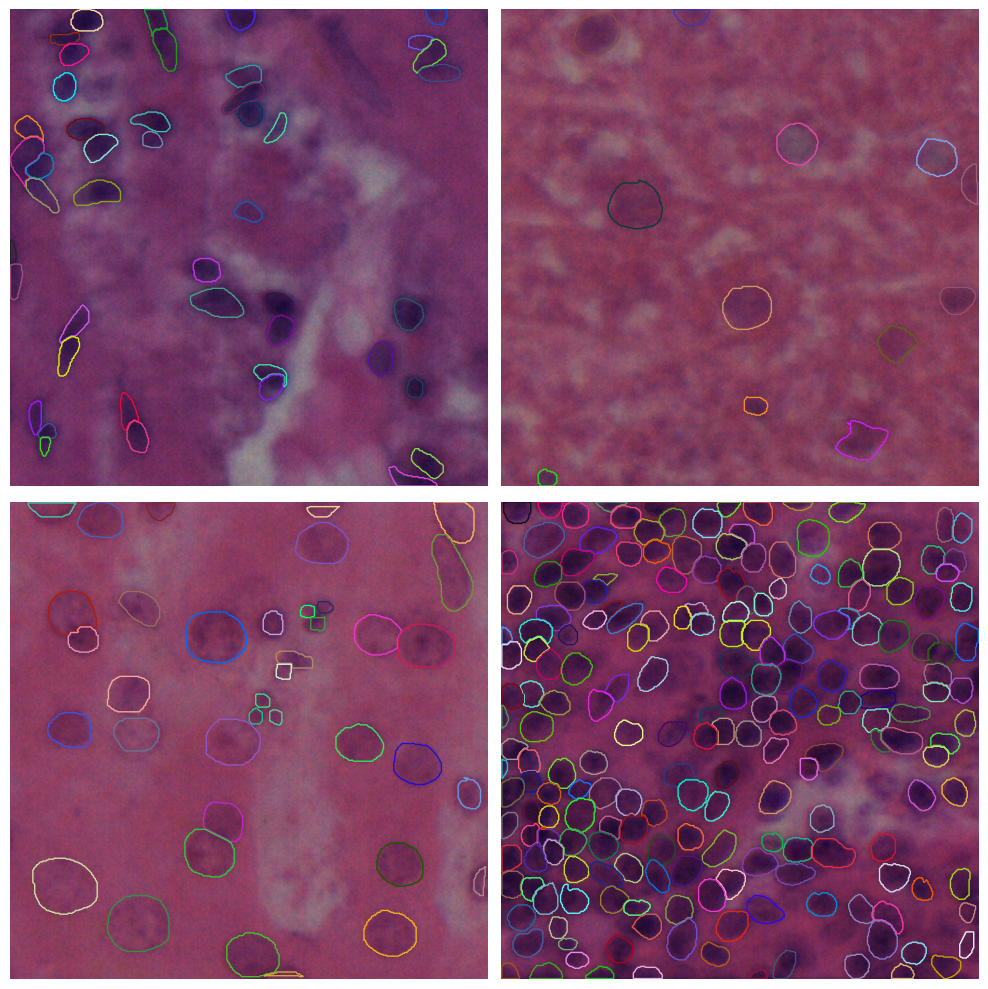

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import numpy as np

def display_images_with_annotations(image_paths, annotation_paths):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    for ax, img_path, ann_path in zip(axs.ravel(), image_paths, annotation_paths):
        # Load image using OpenCV and convert it from BGR to RGB color space
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_h, img_w, _ = image.shape

        ax.imshow(image)
        ax.axis('off')  # Turn off the axes

        # Open the annotation file and process each line
        with open(ann_path, 'r') as file:
            for line in file:
                parts = line.strip().split()
                category_id = int(parts[0])
                color = tuple(np.random.rand(3))  # Generate a random RGB color
                polygon = [float(coord) for coord in parts[1:]]
                polygon = [coord * img_w if i % 2 == 0 else coord * img_h for i, coord in enumerate(polygon)]
                polygon = [(polygon[i], polygon[i+1]) for i in range(0, len(polygon), 2)]
                patch = patches.Polygon(polygon, closed=True, edgecolor=color, fill=False)
                ax.add_patch(patch)

    plt.tight_layout()
    plt.show()

# Get all image files
image_dir = "yolo_dataset/train/images/"
annotation_dir = "yolo_dataset/train/labels/"
all_image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
random_image_files = random.sample(all_image_files, 4)

# Get corresponding annotation files
image_paths = [os.path.join(image_dir, f) for f in random_image_files]
annotation_paths = [os.path.join(annotation_dir, f.replace('.png', '.txt')) for f in random_image_files]

display_images_with_annotations(image_paths, annotation_paths)


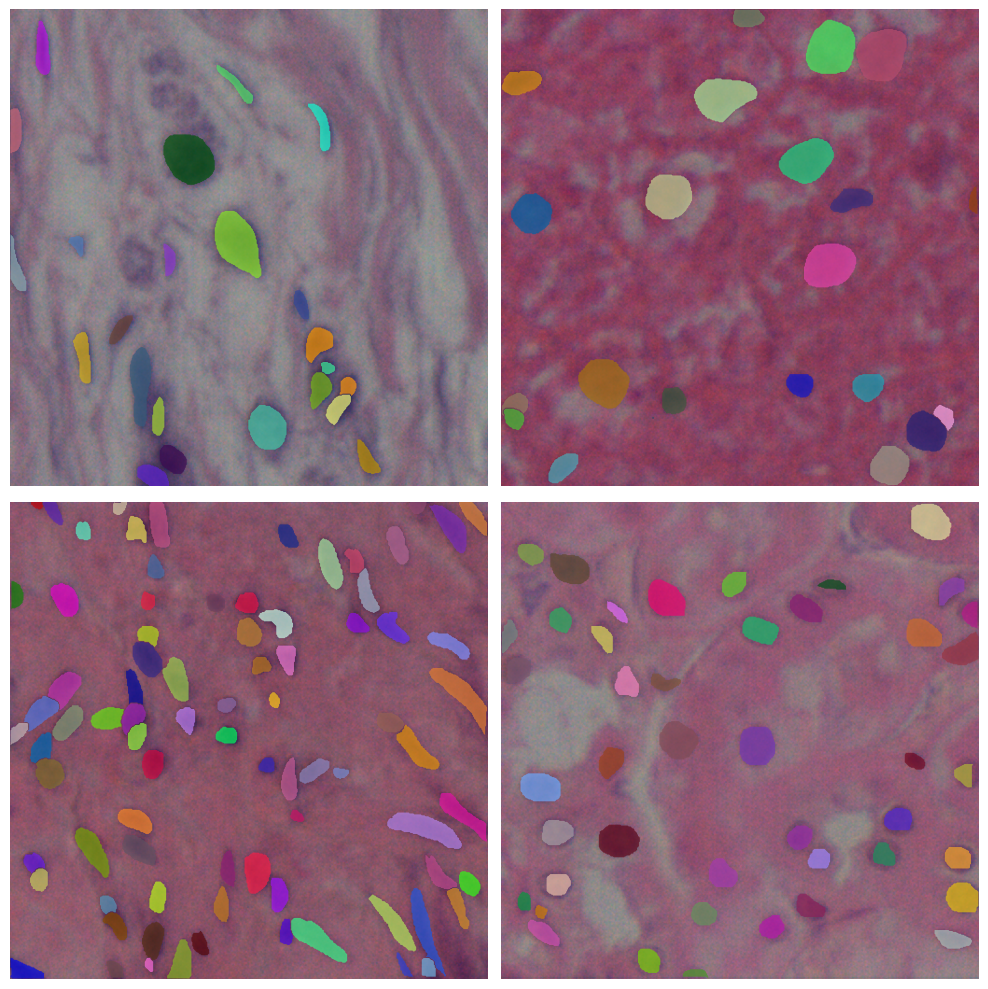

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import numpy as np

def display_images_with_annotations(image_paths, annotation_paths):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    for ax, img_path, ann_path in zip(axs.ravel(), image_paths, annotation_paths):
        # Load image using OpenCV and convert it from BGR to RGB color space
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_h, img_w, _ = image.shape

        ax.imshow(image)
        ax.axis('off')  # Turn off the axes

        # Open the annotation file and process each line
        with open(ann_path, 'r') as file:
            for line in file:
                parts = line.strip().split()
                category_id = int(parts[0])
                fill_color = tuple(np.random.rand(3))  # Generate a random RGB color for filling
                polygon = [float(coord) for coord in parts[1:]]
                polygon = [coord * img_w if i % 2 == 0 else coord * img_h for i, coord in enumerate(polygon)]
                polygon = [(polygon[i], polygon[i+1]) for i in range(0, len(polygon), 2)]
                patch = patches.Polygon(polygon, closed=True, edgecolor='none', facecolor=fill_color, alpha=0.7)
                ax.add_patch(patch)

    plt.tight_layout()
    plt.show()

# Get all image files
image_dir = "yolo_dataset/train/images/"
annotation_dir = "yolo_dataset/train/labels/"
all_image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
random_image_files = random.sample(all_image_files, 4)

# Get corresponding annotation files
image_paths = [os.path.join(image_dir, f) for f in random_image_files]
annotation_paths = [os.path.join(annotation_dir, f.replace('.png', '.txt')) for f in random_image_files]

display_images_with_annotations(image_paths, annotation_paths)

In [ ]:
%cp -r /content/COCO_output /content/drive/MyDrive/Nuclei_data

In [ ]:
%cp -r /content/yolo_dataset /content/drive/MyDrive/Nuclei_data